# Handcoded max-of-$n$

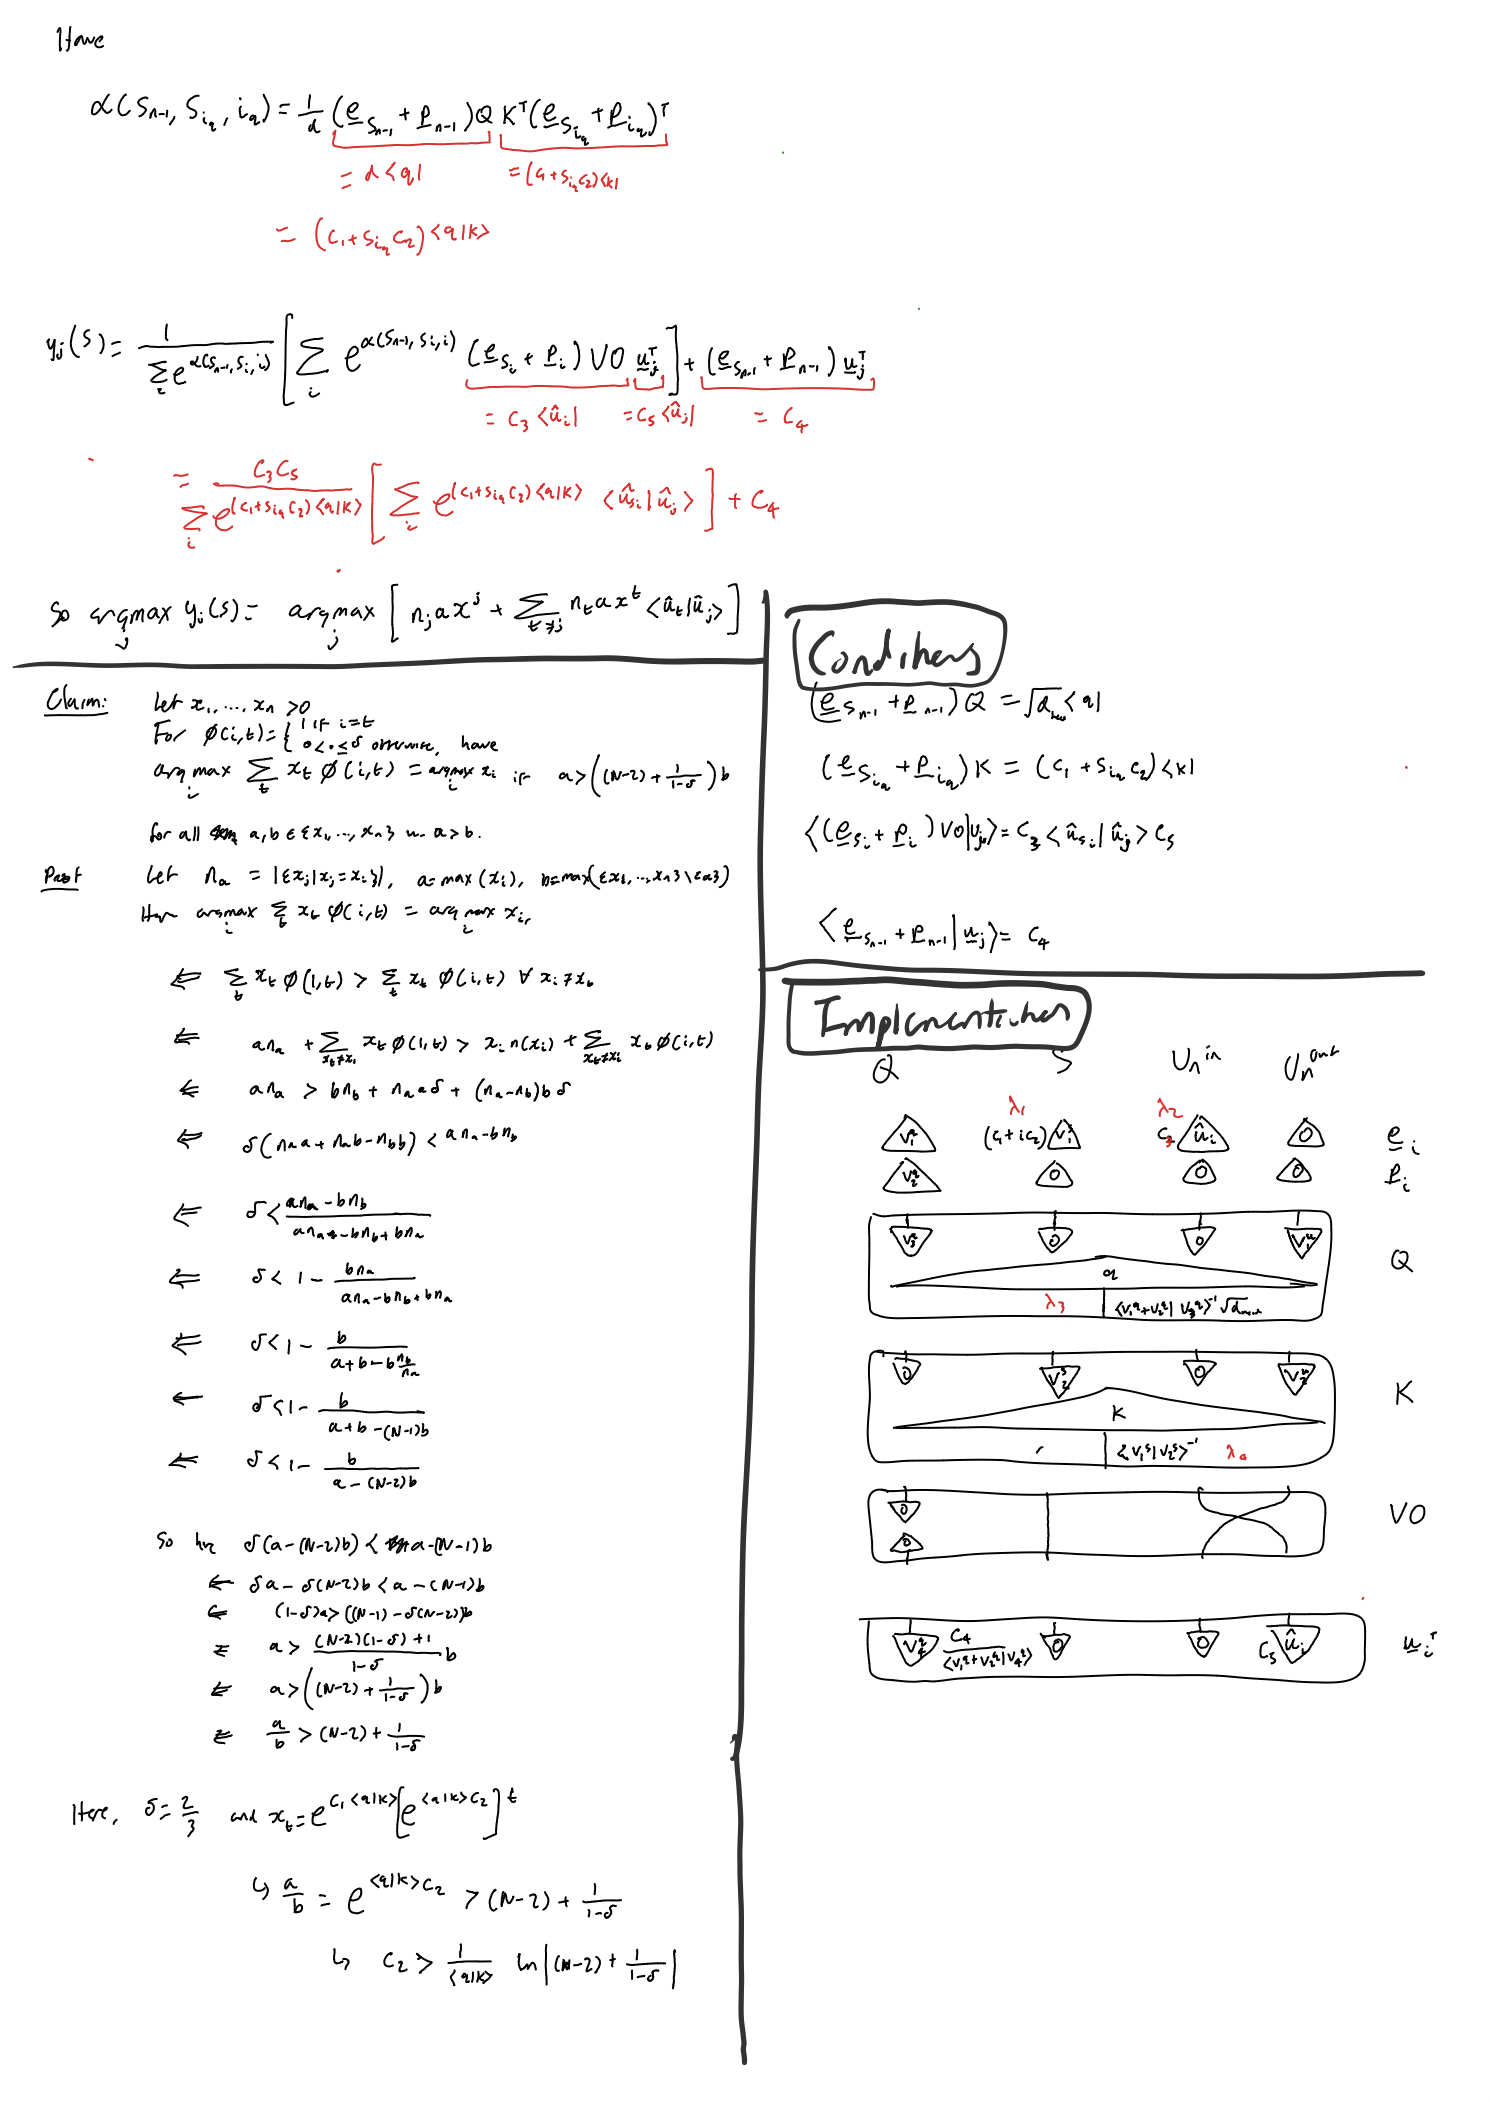

In [1]:
import torch
from jaxtyping import Float
from torch import Tensor
import torch.nn.functional as F

import functools
from einops import rearrange, repeat, reduce
from gbmi.utils import ein

semigroup = lambda f: lambda *args: functools.reduce(f, args)
_in = lambda f: f.shape[0]
_out = lambda f: f.shape[1]
id = lambda n: torch.eye(n)
fst = lambda nl, nr: F.pad(id(nl), (0, 0, 0, nr))
snd = lambda nl, nr: F.pad(id(nr), (0, 0, nl, 0))
fanout = semigroup(lambda f, g: torch.cat([f, g], dim=1))


def test_uprop():
    f = torch.rand(5, 3)
    g = torch.rand(5, 2)
    fg = fanout(f, g)
    assert torch.allclose(fg @ fst(3, 2), f)
    assert torch.allclose(fg @ snd(3, 2), g)


test_uprop()

pair_vec = semigroup(lambda x, y: torch.cat([x, y], dim=1))
pair_fn = semigroup(
    lambda f, g: fanout(fst(_in(f), _in(g)) @ f, snd(_in(f), _in(g)) @ g)
)

swap_pair = lambda nl, nr: fanout(snd(nl, nr), fst(nl, nr))


def test_swap():
    nl = 5
    nr = 3
    assert torch.allclose(swap_pair(nl, nr) @ snd(nr, nl), fst(nl, nr))
    assert torch.allclose(swap_pair(nl, nr) @ fst(nr, nl), snd(nl, nr))


test_swap()

vec = lambda x: x.unsqueeze(0)
zeros = lambda n: torch.zeros(1, n)

In [2]:
def binary(x, bits):
    mask = 2 ** torch.arange(bits).to(x.device, x.dtype)
    return x.unsqueeze(-1).bitwise_and(mask).ne(0).byte().to(x.dtype)

In [3]:
n_vocab = 64
n_pos = 10
d_model = 32
d_head = 32

d_q = 10
d_s = 10
d_u = 6

delta = 1 - 2 / d_u

assert d_q + d_s + d_u + d_u == d_model

vq1, vq2, vq3, vq4 = [vec(torch.rand(d_q)) for _ in range(4)]
vs1, vs2 = [vec(torch.rand(d_s)) for _ in range(2)]
vu1, vu2 = [vec(torch.rand(d_u)) for _ in range(2)]
c1, c3, c4, c5 = [torch.rand(tuple()) for _ in range(4)]

u_hat = binary(torch.arange(2**d_u, dtype=torch.int), d_u) * 2 - 1
q, k = [vec(torch.rand(d_head)) for _ in range(2)]

c2 = 1 / (q @ k.T)[0, 0] * torch.log(torch.tensor(n_pos - 2 + 1 / (1 - delta)))

In [4]:
import math

W_E = ein.array(
    lambda i: pair_vec(vq1, (c1 + i * c2) * vs1, c3 * vec(u_hat[i]), zeros(d_u))[0],
    sizes=[u_hat.shape[0]],
)
W_pos = repeat(
    pair_vec(vq2, zeros(d_s), zeros(d_u), zeros(d_u)), "() h -> n h", n=n_pos
)

W_Q = (
    (pair_vec(vq3, zeros(d_s), zeros(d_u), vu1).T @ q)
    / ((vq1 + vq2) @ vq3.T)
    * math.sqrt(d_head)
)
W_K = (pair_vec(zeros(d_q), vs2, zeros(d_u), vu2).T @ k) / (vs1 @ vs2.T)

W_V = pair_fn(zeros(d_q).T @ zeros(d_q), id(d_s), swap_pair(d_u, d_u))
W_O = id(d_head)

W_U = ein.array(
    lambda i: pair_vec(
        vq4 * c4 / ((vq1 + vq2) @ vq4.T), zeros(d_s), zeros(d_u), c5 * vec(u_hat[i])
    )[0],
    sizes=[u_hat.shape[0]],
).T

/Users/eo/Projects/gbmi/gbmi/utils/ein.py:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(
/Users/eo/Projects/gbmi/gbmi/utils/ein.py:78: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  args_l[0] = torch.tensor(args_l[0])


In [5]:
assert torch.allclose(
    ein.array(lambda s_n1: (W_E[s_n1] + W_pos[9]) @ W_Q), math.sqrt(d_head) * q[0]
)

In [6]:
assert torch.allclose(
    ein.array(lambda s_iq, iq: (W_E[s_iq] + W_pos[iq]) @ W_K),
    ein.array(
        lambda s_iq, iq: (c1 + s_iq * c2) * k[0], sizes=[W_E.shape[0], W_pos.shape[0]]
    ),
)

In [7]:
assert torch.allclose(
    ein.array(lambda i, s_i: (vec(W_E[s_i] + W_pos[i]) @ W_V @ W_O @ W_U)[0]),
    ein.array(lambda s_i, j: (c3 * (vec(u_hat[s_i]) @ vec(u_hat[j]).T) * c5)[0, 0]),
    atol=1e-6,
)

In [8]:
assert torch.allclose(ein.array(lambda s_n1: (W_E[s_n1] + W_pos[9]) @ W_U), c4)

Load model

In [9]:
import torch
from torch import tensor

from gbmi.exp_max_of_n.train import MAX_OF_10_CONFIG
from gbmi.model import train_or_load_model
import gbmi.utils as utils

import gbmi.analysis_tools.l1h1 as l1h1
import gbmi.analysis_tools.plot as plot
import gbmi.analysis_tools.decomp as decomp
import gbmi.analysis_tools.fit as fit
import gbmi.exp_max_of_n.analysis as exp_utils
from gbmi.utils.pretty import pprint
from gbmi.utils import ein
from torch import where
import math

In [10]:
%load_ext autoreload
%autoreload 2

In [11]:
from gbmi.utils.pretty import pprint

In [12]:
def build_l1h1_model(
    W_U: Float[Tensor, "d_model d_vocab"],
    W_E: Float[Tensor, "d_vocab d_model"],
    W_pos: Float[Tensor, "n_pos d_model"],
    W_Q: Float[Tensor, "d_model d_head"],
    W_K: Float[Tensor, "d_model d_head"],
    W_V: Float[Tensor, "d_model d_head"],
    W_O: Float[Tensor, "d_head d_model"],
    config=MAX_OF_10_CONFIG,
):
    model = config.build_model().to(W_U.device)
    model.init_weights()
    with torch.no_grad():
        model.embed.W_E.data = W_E
        model.pos_embed.W_pos.data = W_pos
        model.blocks[0].attn.W_Q.data[0] = W_Q
        model.blocks[0].attn.W_K.data[0] = W_K
        model.blocks[0].attn.W_V.data[0] = W_V
        model.blocks[0].attn.W_O.data[0] = W_O
        model.unembed.W_U.data = W_U
    return model

In [13]:
model = build_l1h1_model(W_U, W_E, W_pos, W_Q, W_K, W_V, W_O)

Moving model to device:  cpu


# Empirical tests

> Pass a sample from the dataloader through the model to check it works.

In [14]:
# dm = config.experiment.get_datamodule()(config)
# dm.setup("fit")

# from tqdm import tqdm

# maxes = set()
# for i, _ in tqdm(dm.data_train):
#     maxes.add(i.max().item())

In [15]:
# t,_ = next(iter(dm.train_dataloader()))

# (t.max(dim=-1).values == model(t).argmax(dim=-1)[:, -1]).float().mean()

Seems to work.

> What if we give 'all the same token' as input?

In [16]:
for i in range(model.cfg.d_vocab):
    result = model(tensor([[i] * 10])).argmax(dim=-1)[0, 0].item()
    print(i, result, i == result)

0 0 True
1 1 True
2 2 True
3 3 True
4 4 True
5 5 True
6 6 True
7 7 True
8 8 True
9 9 True
10 10 True
11 11 True
12 12 True
13 13 True
14 14 True
15 15 True
16 16 True
17 17 True
18 18 True
19 19 True
20 20 True
21 21 True
22 22 True
23 23 True
24 24 True
25 25 True
26 26 True
27 27 True
28 28 True
29 29 True
30 30 True
31 31 True
32 32 True
33 33 True
34 34 True
35 35 True
36 36 True
37 37 True
38 38 True
39 39 True
40 40 True
41 41 True
42 42 True
43 43 True
44 44 True
45 45 True
46 46 True
47 47 True
48 48 True
49 49 True
50 50 True
51 51 True
52 52 True
53 53 True
54 54 True
55 55 True
56 56 True
57 57 True
58 58 True
59 59 True
60 60 True
61 61 True
62 62 True
63 63 True


# Introducing the model

In [17]:
from gbmi.utils import ein
from math import sqrt
from torch import exp

U, e, p, Q, K, V, O = [
    i.squeeze().clone().detach()
    for i in [
        model.W_U,
        model.W_E,
        model.W_pos,
        model.W_Q,
        model.W_K,
        model.W_V,
        model.W_O,
    ]
]
d_head = model.cfg.d_head
d = sqrt(d_head)

s = torch.tensor([0, 1, 32, 33, 34, 35, 39, 37, 62, 63])
n = len(s)

> **NOTE:** We're using right-multiplication of matrices (i.e. $\vv{v}$ is a row-vector by default), and zero-based indexing.

Consider a 1-layer attention-only transformer, consuming a sequence of $n$ input tokens $(s_0,...,s_{n-1})$, with
- hidden dimension $h$
- head dimension $d_{head}$
- vocabulary size $v$ (representing numbers 0 to $v-1$ with token indices 0 to $v-1$)

Let $d = \sqrt{d_{head}}$, $\vv{e}_t = (W_E)_t$, and $\vv{p}_i = (W_{pos})_i$.

Then the unnormalised attention from position $n-1$ (storing token $s_{n-1}$) to position $i_q$ (storing token $s_{i_q}$) is given by
$$\alpha(s_{n-1}, s_{i_q}, i_q) = \f{1}{d} (\vv{e}_{s_{n-1}} + \vv{p}_{n-1}) Q K^T (\vv{e}_{s_{i_q}} + \vv{p}_{i_q})^T$$

In [18]:
α = ein.array(
    lambda s_n1, s_i_q, i_q: (1 / d)
    * (e[s_n1] + p[n - 1])
    @ Q
    @ K.T
    @ (e[s_i_q] + p[i_q]).T
)
α_offset = (α.max() + α.min()) / 2
α = α - α_offset

/Users/eo/Projects/gbmi/gbmi/utils/ein.py:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(
/var/folders/y1/33lbjdps12lf6x0csm_rvb5m0000gn/T/ipykernel_4927/1222669442.py:6: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3641.)
  @ (e[s_i_q] + p[i_q]).T


and the output logit vector (at position ${n-1}$) is given by
$$\vv{y}(\vv{s}) = \f{1}{\sum_{i=0}^{{n-1}} e^{\alpha(s_{n-1}, s_i, i) - \alpha_{offset}}} 
\left[\sum_{i=0}^{n-1} e^{\alpha(s_{{n-1}}, s_i, i) - \alpha_{offset}} (\vv{e}_{s_i} + \vv{p}_i)VOU\right]
+ (\vv{e}_{s_{n-1}} + \vv{p}_{n-1})U$$
such that $y_i(\vv{s})$ corresponds to the output logit for token $i\in \cbr{0, ...,v-1}$.

In [19]:
y = lambda s: (
    (
        1
        / ein.sum(lambda i: exp(α[s[n - 1], s[i], i] - α_offset))
        * ein.sum(
            lambda i: exp(α[s[n - 1], s[i], i] - α_offset)
            * (e[s[i]] + p[i])
            @ V
            @ O
            @ U
        )
    )
    + (e[s[n - 1]] + p[n - 1]) @ U
)
true_logits = model(torch.tensor(s))
assert torch.allclose(y(torch.tensor(s)), true_logits.squeeze()[-1], atol=1e-5)

/var/folders/y1/33lbjdps12lf6x0csm_rvb5m0000gn/T/ipykernel_4927/1003047524.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  true_logits = model(torch.tensor(s))
/var/folders/y1/33lbjdps12lf6x0csm_rvb5m0000gn/T/ipykernel_4927/1003047524.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  assert torch.allclose(y(torch.tensor(s)), true_logits.squeeze()[-1], atol=1e-5)


Alternatively, we can write $y_t(\vv{s})$ in terms of

- the _residual logit contribution for $t$ from position $n-1$ (with value $s_{n}$)_:

$$r(t, s_{{n-1}}) = [(\vv{e}_{s_{{n-1}}} + \vv{p}_{{n-1}})U]_t$$

- the _OV logit contribution for $t$ from position $i$ (with value $s_i$)_:

$$v(t, i, s_i) = [(\vv{e}_{s_iz} + \vv{p}_i)VOU]_t$$

as

$$y_t(\vv{s}) = \f{1}{\sum_{i=0}^{{n-1}} e^{\alpha(s_{n-1}, s_i, i)}} 
\left[\sum_{i=0}^{n-1} e^{\alpha(s_{{n-1}}, s_i, i)} v(t, i, s_i)\right]
+ r(t, s_{{n-1}})$$

In [20]:
A = torch.rand(4, 2)

In [21]:
i0 = ein.ConstraintTrackingTensor(torch.tensor(0))

In [22]:
from functorch.dim import dims

dim = dims(1)
idx = torch.arange(2)[dim]

In [23]:
A[i0][idx]

tensor([0.3943, 0.5162])
with dims=(dim,) sizes=(2,)

In [24]:
A[0]

tensor([0.3943, 0.5162])

In [25]:
A[0][idx]

tensor([0.3943, 0.5162])
with dims=(dim,) sizes=(2,)

In [26]:
ein.array(lambda i, j: A[i][j])

tensor([[0.3943, 0.5162],
        [0.1094, 0.2265],
        [0.6334, 0.5859],
        [0.9696, 0.7646]])

In [27]:
r = ein.array(lambda t, s_n1: ((e[s_n1] + p[n - 1]) @ U)[t])
v = ein.array(lambda t, i, s_i: ((e[s_i] + p[i]) @ V @ O @ U)[t])

In [28]:
y_t = lambda t, s: (
    1
    / ein.sum(lambda i: exp(α[s[n - 1], s[i], i]))
    * ein.sum(lambda i: exp(α[s[n - 1], s[i], i]) * v[t, i, s[i]])
    + r[t, s[n - 1]]
)

In [29]:
assert torch.allclose(y_t(0, s), true_logits.squeeze()[-1, 0], atol=1e-5)

# The problem

We're interested in bounding the _$\eps$-accuracy_ of our transformer over some target set $S\subseteq \cbr{0,...,v-1}^{n}$ -- in other words, the fraction of times the difference between the output logit for token $\max(\vv{s})$ and the next highest output logit is $> \eps$, over sequences $\vv{s}\in S$:

$$\begin{aligned}
acc_\eps(S) &= \frac{1}{|S|}\sum_{\vv{s}\in S}1[y_{\max(\vv{s})}(\vv{s}) - y_{t}(\vv{s}) > \eps \; \forall t\in \vv{s}]\\
&= \frac{1}{|S|}\sum_{\vv{s}\in S}1[y_{\max(\vv{s})}(\vv{s}) - \max_{t\in \vv{s}} y_{t}(\vv{s}) - \eps > 0]
\end{aligned}$$

# Initial bound

While naïvely evaluating $acc_\eps(S)$ would take time exponential in the length of our sequence, we can obtain a lower bound on $acc_\eps(S)$ by identifying subsets $U\subseteq S$ of valid sequences $\vv{s}$ (i.e. such that $y_{\max(\vv{s})}(\vv{s}) - \max_{t\in \vv{s}} y_{t}(\vv{s}) - \eps > 0$).

As such, we ask: for tokens $t_1 = \max(\vv{s})$ and arbitrary $t_2$, what conditions on $\vv{s}$ imply $y_{t_1}(\vv{s})-y_{t_2}(\vv{s}) - \eps > 0$?

Have $$\begin{aligned}
0 &\leq y_{t_1}(\vv{s}) - y_{t_2}(\vv{s})-\eps\\
\iff 0&\leq \f{1}{\sum_{i=0}^{{n-1}} e^{\alpha(s_{n-1}, s_i, i)}} 
\left[\sum_{i=0}^{n-1} e^{\alpha(s_{{n-1}}, s_i, i)} (v(t_1, i, s_i) - v(t_2, i, s_i))\right] \\
&+ r(t_1, s_{n-1}) - r(t_2, s_{n-1})-\eps\\
\iff 0 &\leq \sum_{i=0}^{n-1} e^{\alpha(s_{{n-1}}, s_i, i)} [v(t_1, i, s_i) - v(t_2, i, s_i)] \\
&+ \sum_{i=0}^{{n-1}} e^{\alpha(s_{n-1}, s_i, i)} [r(t_1, s_{n-1}) - r(t_2, s_{n-1})-\eps]\\
\iff 0 &\leq \sum_{i=0}^{n-1} e^{\alpha(s_{{n-1}}, s_i, i)} [v(t_1, i, s_i) - v(t_2, i, s_i) + 
 r(t_1, s_{n-1}) - r(t_2, s_{n-1})-\eps] = \sum_{i=0}^{n-1} \Delta_\eps^{(1)}(t_1, t_2, i, s_i, s_{n-1})
\end{aligned}$$

> Intuitively, $\Delta_\eps^{(1)}$ is the contribution to the logit difference $y_{t_1}(\vv{s}) - y_{t_2}(\vv{s})$ due to attending to position $i$.

Now, pessimising over the position index $i$ of the query token, have
$$\begin{aligned}
\impliedby 0 &\leq \sum_{i=0}^{n-1} \min_{j\in P} \left( e^{\alpha(s_{{n-1}}, s_i, j)} [v(t_1, j, s_i) - v(t_2, j, s_i) + 
 r(t_1, s_{n-1}) - r(t_2, s_{n-1})-\eps]\right) = \sum_{i=0}^{n-1} \Delta_\eps^{(2)}(t_1, t_2, s_i, s_{n-1}) \\
\end{aligned}$$

And pessimising over the token value $s_{n-1}$ (which must be $\leq t_1 = \max(\vv{s})$), have
$$\begin{aligned}
\impliedby 0 &\leq \sum_{i=0}^{n-1} \min_{j\in P, s_{n-1}\leq t_1} \left( e^{\alpha(s_{{n-1}}, s_i, j)} [v(t_1, j, s_i) - v(t_2, j, s_i) + 
 r(t_1, s_{n-1}) - r(t_2, s_{n-1})-\eps]\right) = \sum_{i=0}^{n-1} \Delta_\eps^{(3)}(t_1, t_2, s_i) \\
\end{aligned}$$

Now, since $\Delta_\eps^{(3)}$ is invariant to permutations of $\vv{s}$, suppose $\vv{s}$ contains $\#_x(\vv{s})$ copies of token $x$. Then have

$$\begin{aligned}
\impliedby 0 &\leq \sum_{s=0}^{|V|-1} \#_s(\vv{s}) \Delta_\eps^{(3)}(t_1, t_2, s)\\
\impliedby 0 &\leq (n-1) \min_{s\in \vv{s}} \Delta_\eps^{(3)}(t_1, t_2, s)+ \Delta_\eps^{(3)}(t_1, t_2, \max(\vv{s}))\\
\end{aligned}$$

by convexity.

---

A sequence $\vv{s}$ is correctly recognised (with logit gap $\eps$) if

$$\begin{aligned}
0 &\leq \min_{t_{attn}\in \vv{s}, t_{cmp}\in V} \sqbr{(n-1)\Delta_\eps^{(3)}(\max(\vv{s}), t_{cmp}, t_{attn}) + \Delta_\eps^{(3)}(\max(\vv{s}), t_{cmp}, \max(\vv{s}))}\\
\impliedby 0 &\leq \min_{t_{attn}\in \vv{s}} \sqbr{(n-1)\Delta_\eps^{(3)}(\max(\vv{s}), t_{cmp}, t_{attn}) + \Delta_\eps^{(3)}(\max(\vv{s}), t_{cmp}, \max(\vv{s}))}=\min_{t_{attn}\in \vv{s}} \Delta_\eps^{(4)}(\max(\vv{s}), t_{attn})\\
\end{aligned}$$

Hence, for tokens $t_{max}$, $t_{attn}$, if 

$$0 \leq \Delta_\eps^{(4)}(t_{max}, t_{attn}) $$

then our model correctly recognises all sequences $\vv{s}$ for which
- $t_{max}=\max(\vv{s})$, and
- $t_{attn}\in \vv{s}$ is the element for which $\Delta_\eps^{(4)}(t_{max}, t_{attn})$ is minimised

---

## Computing the bound

In [30]:
from gbmi.utils import ein
from torch import where

To count the number of sequences, we first precompute

$$\boxed{
\begin{aligned}
\alpha(\complexity{O(nv^2)}{s_{n-1}, s_{i_q}, i_q}) &= \complexity{O(h^2)}{\f{1}{d} (\vv{e}_{s_{n-1}} + \vv{p}_{n-1}) Q K^T (\vv{e}_{s_{i_q}} + \vv{p}_{i_q})^T}\\
r(\complexity{O(v)}{t, s_{{n-1}}}) &= \complexity{O(hv)}{[(\vv{e}_{s_{{n-1}}} + \vv{p}_{{n-1}})U]_t}\\
v(\complexity{O(nv)}{t, i, s_i}) &= \complexity{O(h^2+hv)}{[(\vv{e}_{s_i} + \vv{p}_i)VOU]_t}\\
\Delta_\eps^{(3)}(\complexity{O(v^3)}{t_1, t_2, s_i}) &= \complexity{O(nv)}{\min_{j\in P, s_{n-1}\leq t_1} \left( e^{\alpha(s_{{n-1}}, s_i, j)} [v(t_1, j, s_i) - v(t_2, j, s_i) + 
 r(t_1, s_{n-1}) - r(t_2, s_{n-1})-\eps]\right)}\\
\Delta_\eps^{(4)}(\complexity{O(v^2)}{\max(\vv{s}), t_{attn}}) &= \complexity{O(v)}{\min_{t_{cmp}\in V} \sqbr{(n-1)\Delta_\eps^{(3)}(\max(\vv{s}), t_{cmp}, t_{attn}) + \Delta_\eps^{(3)}(\max(\vv{s}), t_{cmp}, \max(\vv{s}))}}
\end{aligned}}$$

with time complexity $\color{darkred}O(nv^2h^2 + nv^4)$.

In [31]:
ϵ = 0
Δ_ϵ_3 = ein.array(
    lambda t_1, t_2, s_i: ein.min(
        lambda j, s_n1: where(
            (s_n1 <= t_1),
            exp(α[s_n1, s_i, j])
            * (v[t_1, j, s_i] - v[t_2, j, s_i] + r[t_1, s_n1] - r[t_2, s_n1] - ϵ),
            1e13,
        ),
        sizes=[α.shape[2], α.shape[0]],
    ),
    sizes=[r.shape[0], r.shape[0], α.shape[1]],
)

In [32]:
Δ_ϵ_4 = ein.array(
    lambda max_s, t_attn: ein.min(
        lambda t_cmp: (n - 1) * Δ_ϵ_3[max_s, t_cmp, t_attn] + Δ_ϵ_3[max_s, t_cmp, max_s]
    ),
)

---

Now, to find the number of possible sequences with a given maximum element $t_{max}$, note that any such sequence must contain at least one instance of $t_{max}$, with all other elements being chosen from a set of size

$$c(t_{max}) = \max\br{0, t_{max} + 1 - \min\cbr{t_{attn} \in V \mid 0 \leq \Delta_\eps^{(4)}(t_{max}, t_{attn}) \land t_{attn} \leq t_{max}}}$$

(containing $t_{max}$).

So, by considering all possible sequences with $c(t_{max})$ elements and discounting those not containing $t_{max}$, we have a total of

$$c(t_{max})^n - (c(t_{max})-1)^n$$

possible sequences.

In total, this part of the computation has time complexity $\color{darkred}O(v^2)$.

In [33]:
c = ein.array(
    lambda t_max: torch.maximum(
        torch.tensor(0),
        -ein.min(
            lambda t_attn: where(
                (0 <= Δ_ϵ_4[t_max, t_attn]) & (t_attn <= t_max), t_attn, 1e9
            )
        )
        + t_max
        + 1,
    ),
)

---
We can now compute the lower bound:

In [34]:
torch.maximum(c**10 - (c - 1) ** 10, torch.tensor(0)).sum() / (U.shape[-1] ** 10)

tensor(1.)

Overall, this lower bound has time complexity $\color{darkred}O(nv^2h^2 + nv^4)$.

## Discussion

This seems very high! But for a bit more granularity, we can plot (a lower bound on) the set of tokens $s\in \max(\vv{s})$ compatible with $\max(\vv{s})$ for different values of $\max(\vv{s})$.

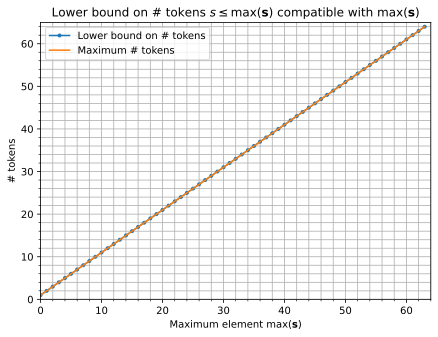

In [35]:
import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'svg'
plt.rcParams["figure.dpi"] = 150

plt.figure(figsize=(7, 5))
plt.plot(c, marker=".", label="Lower bound on # tokens")
plt.plot(torch.arange(0, 64), torch.arange(1, 65), label="Maximum # tokens")

plt.title(
    "Lower bound on # tokens $s\leq \max({\mathbf{s}})$ compatible with $\max({\mathbf{s}})$"
)
plt.legend(loc="best")
plt.xlabel("Maximum element $\max({\mathbf{s}})$")
plt.ylabel("# tokens")
plt.grid(which="both")
plt.minorticks_on()
plt.ylim(ymin=0, ymax=65)
plt.xlim(xmin=0, xmax=64)
plt.show()

Observe that, while our lower bound on accuracy for sequences with $\max(\mathbf{s}) < 30$ is ~0, we still get an extremely high lower bound for the overall problem, because sequences with $\max(\mathbf{s}) < 30$ make up such a small fraction of the overall distribution:

In [36]:
num_seqs_with_max = lambda m: (m + 1) ** n - m**n

In [37]:
num_seqs_with_max_leq = lambda m: m**n

In [38]:
num_seqs_with_max_leq(29) / num_seqs_with_max_leq(63)

0.00042714417128587347

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


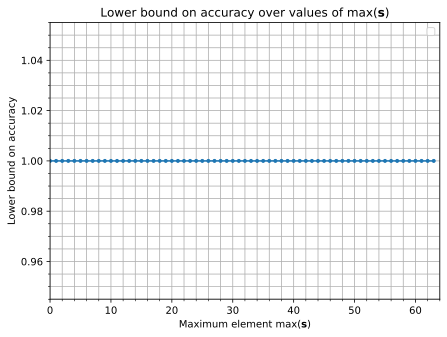

In [39]:
import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'svg'
plt.rcParams["figure.dpi"] = 150

plt.figure(figsize=(7, 5))
plt.plot(
    [
        max(num_seqs_with_max(int(i) - 1), 0) / num_seqs_with_max(z)
        for z, i in enumerate(c)
    ],
    marker=".",
)

plt.title("Lower bound on accuracy over values of $\max(\mathbf{s})$")
plt.legend(loc="best")
plt.xlabel("Maximum element $\max({\mathbf{s}})$")
plt.ylabel("Lower bound on accuracy")
plt.grid(which="both")
plt.minorticks_on()
# plt.ylim(ymin=0, ymax=65)
plt.xlim(xmin=0, xmax=64)
plt.show()

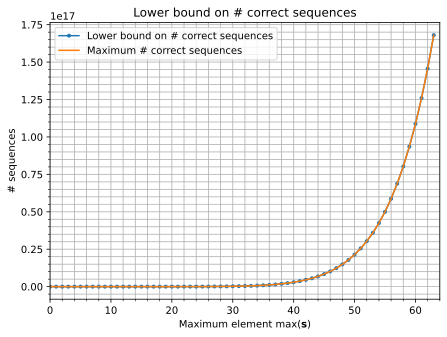

In [40]:
import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'svg'
plt.rcParams["figure.dpi"] = 150

plt.figure(figsize=(7, 5))
plt.plot(
    [num_seqs_with_max(int(i) - 1) for i in c],
    marker=".",
    label="Lower bound on # correct sequences",
)
plt.plot([num_seqs_with_max(i) for i in range(64)], label="Maximum # correct sequences")

plt.title("Lower bound on # correct sequences")
plt.legend(loc="best")
plt.xlabel("Maximum element $\max({\mathbf{s}})$")
plt.ylabel("# sequences")
plt.grid(which="both")
plt.minorticks_on()
# plt.ylim(ymin=0, ymax=65)
plt.xlim(xmin=0, xmax=64)
plt.show()

**Remark:** Without scaling, we fail after element ~19... interestingly, this is the point before which we always used to fail.